## CNN
- 미분을 활용해서 경계선을 구한다. 
- convolutional filter를 사용해서 사진에서 특징을 검출한다. 
- Convolution: 특정 패턴이 있는지 박스로 훑으며 마킹 
- MaxPooling: 사진을 점진적으로 줄이는 방법 
- Convolutional Layer: 패턴들을 쌓아가며 점차 복잡한 패턴을 인식한다. 레이어 사이즈를 줄여가며 더욱 추상화 해나간다.(maxpooling)
- Zero padding: 귀퉁이를 자르면서 사이즈를 유지하기 위해 모서리에 0을 추가한다. 
- Dropout: overfitting을 방지하기 위해 학습시킬 때, 일부러 정보를 누락시키거나 중간 중간 노드를 끈다.

#### 데이터 준비 

In [2]:
from tensorflow.keras import datasets

mnist = datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255, X_test / 255

X_train = X_train.reshape((60000, 28, 28, 1))   # chanel 때문에 3차원으로 맞추기 위해 1 추가 
X_test = X_test.reshape((10000, 28, 28, 1))

#### 모델 생성

In [3]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),  # chanel 32개 
                padding='same', activation='relu', 
                input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),   #stride는 1
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                             

2022-07-07 16:41:18.759289: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-07 16:41:18.759419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### 컴파일

In [4]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

%time
hist = model.fit(X_train, y_train, epochs=5, verbose=1, validation_data= (X_test, y_test))
# accuracy를 측정하기 위해서는 validation_data 지정 

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 2.86 µs
Epoch 1/5


2022-07-07 16:41:19.072131: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-07 16:41:19.267534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 788/1875 [===========>..................] - ETA: 12s - loss: 0.1803 - accuracy: 0.9435

KeyboardInterrupt: 

#### 훈련 양상 확인 

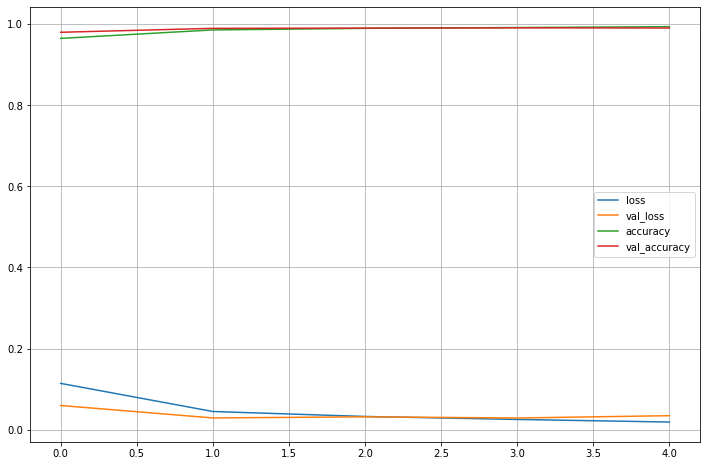

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
plt.figure(figsize=(12, 8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.0344 - accuracy: 0.9906
Test loss : 0.0344000980257988
Test accuracy : 0.990600049495697


- loss가 낮고, accuracy가 높은 것으로 보아 학습이 잘 된 것으로 보인다.  

#### 틀린 데이터 찾기 

In [ ]:
import numpy as np 

predicted_result = model.predict(X_test)
predicted_labels = np.argmax(predicted_result, axis=1)
predicted_labels[:10]

 43/313 [===>..........................] - ETA: 1s

2022-07-07 15:39:15.265729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 5ms/step


array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [ ]:
wrong_result = []

for n in range(0, len(y_test)):
    if predicted_labels[n] != y_test[n]:
        wrong_result.append(n)

len(wrong_result)

94

In [ ]:
import random

samples = random.choices(population=wrong_result, k=16)
samples

[813,
 3558,
 4507,
 2462,
 551,
 6576,
 1014,
 115,
 1232,
 2129,
 9642,
 1232,
 3005,
 158,
 4507,
 1182]

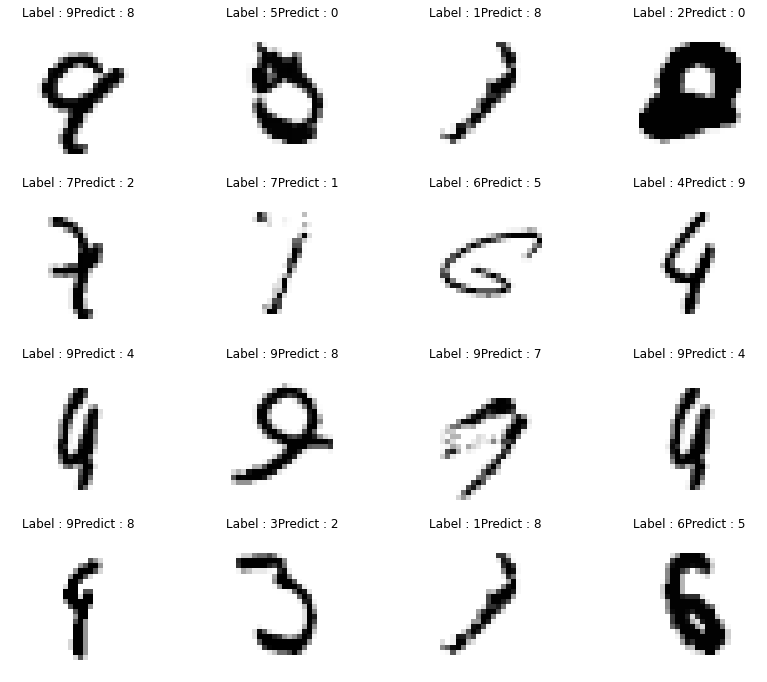

In [ ]:
plt.figure(figsize=(14, 12))

for idx, n in enumerate(samples):
    plt.subplot(4, 4, idx+1)
    plt.imshow(X_test[n].reshape(28, 28), cmap='Greys', interpolation='nearest')
    plt.title('Label : ' + str(y_test[n]) + 'Predict : ' + str(predicted_labels[n]))
    plt.axis('off')

plt.show()

In [ ]:
# 모델 저장 
model.save('MNIST_CNN_model.h5')

## fashion MNIST에 적용 

In [ ]:
from tensorflow.keras import datasets

mnist = datasets.fashion_mnist  # 데이터만 다르게 지정하고 나머지 코드는 동일 

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255, X_test / 255

X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),  # chanel 32개 
                padding='same', activation='relu', 
                input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),   #stride는 1
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 3136)             

In [ ]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

%time
hist = model.fit(X_train, y_train, epochs=5, verbose=1, validation_data= (X_test, y_test))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Epoch 1/5
   4/1875 [..............................] - ETA: 42s - loss: 2.1626 - accuracy: 0.2500  

2022-07-07 15:39:18.578051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.8561

2022-07-07 15:39:39.491788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 23s 12ms/step - loss: 0.3902 - accuracy: 0.8561 - val_loss: 0.3077 - val_accuracy: 0.8884
Epoch 2/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2655 - accuracy: 0.9017 - val_loss: 0.2564 - val_accuracy: 0.9082
Epoch 3/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2247 - accuracy: 0.9160 - val_loss: 0.2614 - val_accuracy: 0.9086
Epoch 4/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1929 - accuracy: 0.9274 - val_loss: 0.2469 - val_accuracy: 0.9098
Epoch 5/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1654 - accuracy: 0.9379 - val_loss: 0.2436 - val_accuracy: 0.9167


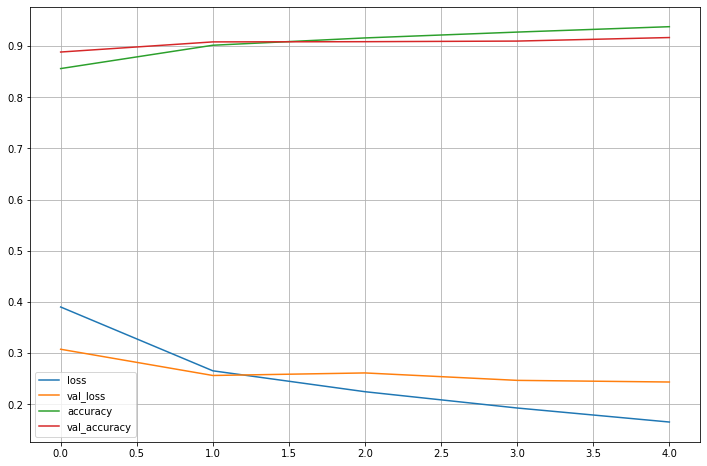

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
plt.figure(figsize=(12, 8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

- 약간의 과적합이 관찰된다. 

In [34]:
score = model.evaluate(X_test, y_test)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.2436 - accuracy: 0.9167
Test loss : 0.24363301694393158
Test accuracy : 0.9167000651359558


## MNIST using CNN 

#### 데이터 준비 

In [5]:
import tensorflow as tf

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255, X_test / 255

X_train = X_train.reshape((60000, 28, 28, 1))  
X_test = X_test.reshape((10000, 28, 28, 1))

#### 모델 생성 

In [6]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(3, kernel_size=(3, 3), strides=(1, 1),
                    padding='same', activation='relu',
                    input_shape=(28, 28, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 3)         30        
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 3)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 588)               0         
                                                                 
 dense_2 (Dense)             (None, 1000)              589000    
                                                                 
 dense_3 (Dense)             (None, 10)                10010     
                                                      

In [8]:
model.layers

In [9]:
# 학습 전 convolutional weight의 평균 
conv = model.layers[0]
conv_weights = conv.weights[0].numpy()
conv_weights, conv_weights.mean(), conv_weights.std()     #random weight

(array([[[[-0.1536704 ,  0.26645654,  0.15100741]],
 
         [[-0.40277034,  0.23473883, -0.08928299]],
 
         [[-0.16931646,  0.40185452,  0.37404054]]],
 
 
        [[[ 0.0459142 , -0.27380157, -0.29846454]],
 
         [[-0.30022696,  0.02842212,  0.05789104]],
 
         [[ 0.00792414, -0.01426956, -0.28103375]]],
 
 
        [[[-0.10588107, -0.00644487,  0.05471835]],
 
         [[-0.23865494, -0.2594509 ,  0.40729898]],
 
         [[-0.10654801, -0.09856865,  0.2223416 ]]]], dtype=float32),
 -0.02021395,
 0.225779)

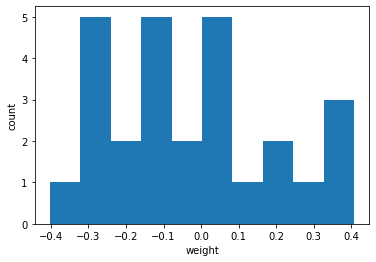

In [41]:
import matplotlib.pyplot as plt

plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

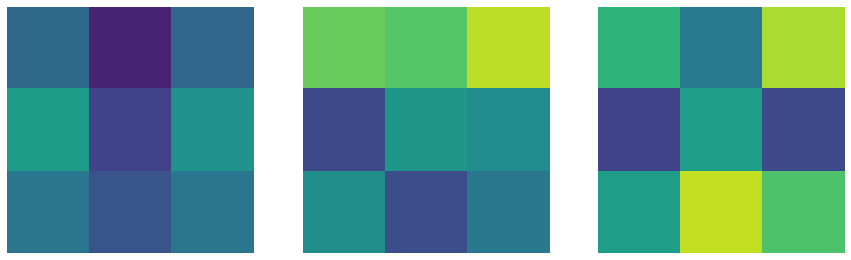

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(conv_weights[:, :, 0, i], vmin=-0.5, vmax=0.5)     #한 figure에 그린 값들이 같은 range의 색상을 지니도록 vmin, vmax 지정 
    ax[i].axis('off')

plt.show()

In [43]:
%time
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
hist = model.fit(X_train, y_train, epochs=5, verbose=1, validation_data = (X_test, y_test))

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs
Epoch 1/5


2022-07-07 15:57:04.322449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1870/1875 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9264

2022-07-07 15:57:19.344845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 16s 8ms/step - loss: 0.2374 - accuracy: 0.9265 - val_loss: 0.0980 - val_accuracy: 0.9691
Epoch 2/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.1118 - accuracy: 0.9646 - val_loss: 0.0727 - val_accuracy: 0.9759
Epoch 3/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0825 - accuracy: 0.9733 - val_loss: 0.0592 - val_accuracy: 0.9805
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0671 - accuracy: 0.9784 - val_loss: 0.0505 - val_accuracy: 0.9827
Epoch 5/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0545 - accuracy: 0.9821 - val_loss: 0.0492 - val_accuracy: 0.9841


#### 학습 후 conv filter 변화 
- filter는 하나의 특징을 나타내는 weight 

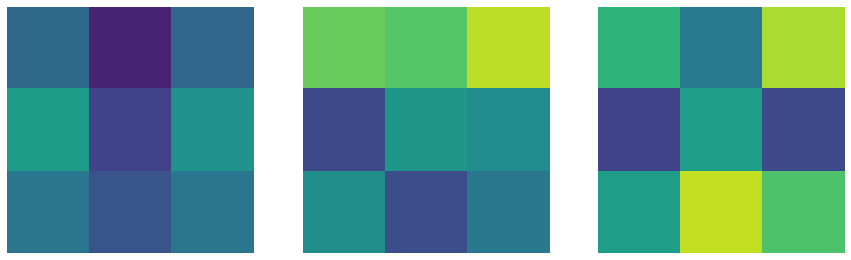

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(conv_weights[:, :, 0, i], vmin=-0.5, vmax=0.5)
    ax[i].axis('off')

plt.show()

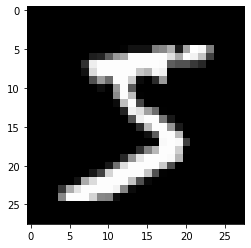

In [45]:
plt.imshow(X_train[0], cmap='gray');

In [46]:
# convolutional layer의 layer 하나를 추출 
inputs = X_train[0].reshape(-1, 28, 28, 1)
conv_layer_output = tf.keras.Model(model.input, model.layers[0].output)
conv_layer_output.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9_input (InputLayer)  [(None, 28, 28, 1)]      0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 3)         30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [47]:
feature_maps = conv_layer_output.predict(inputs)
feature_maps.shape

1/1 [==============================] - 0s 159ms/step


2022-07-07 15:59:32.661967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(1, 28, 28, 3)

In [48]:
feature_maps[0, :, :, 0].shape

(28, 28)

#### Feature map 이 본 숫자 5

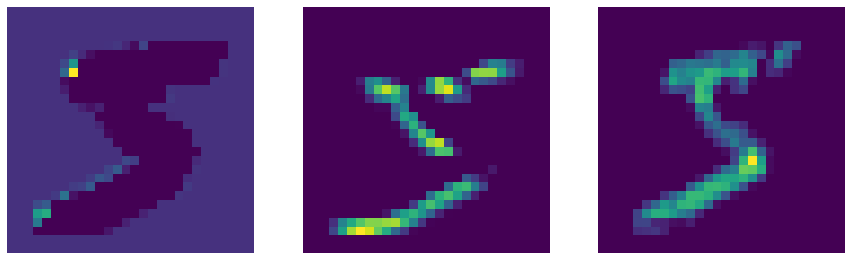

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(feature_maps[0, :, :, i])
    ax[i].axis('off')

plt.show()

#### 함수화

In [54]:
def draw_feature_maps(n):
    inputs = X_train[n].reshape(-1, 28, 28, 1)
    feature_maps = conv_layer_output.predict(inputs)

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))

    ax[0].imshow(inputs[0, :, :, 0], cmap='gray');
    for i in range(1, 4):
        ax[i].imshow(feature_maps[0, :, :, i-1])
        ax[i].axis('off')

    plt.show()

1/1 [==============================] - 0s 8ms/step


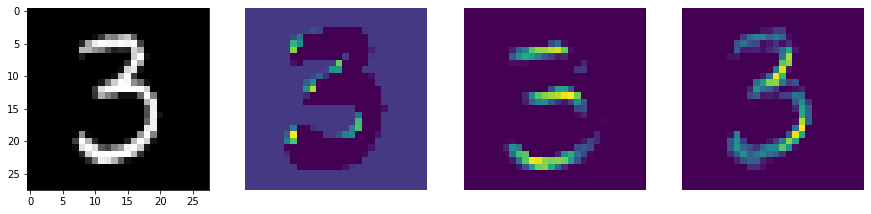

In [55]:
draw_feature_maps(50)

1/1 [==============================] - 0s 11ms/step


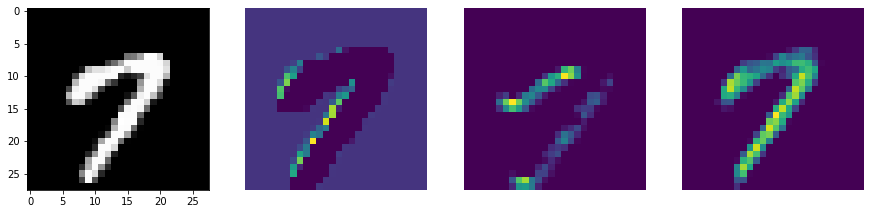

In [56]:
draw_feature_maps(15)

#### 모델 채널 증가 

In [57]:
model1 = models.Sequential([
    layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1),
                    padding='same', activation='relu',
                    input_shape=(28, 28, 1)),
    layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [58]:
%time
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
hist = model1.fit(X_train, y_train, epochs=5, verbose=1, 
                validation_data = (X_test, y_test))

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.86 µs
Epoch 1/5


2022-07-07 16:20:27.079662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1871/1875 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9490

2022-07-07 16:20:46.808262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 21s 11ms/step - loss: 0.1677 - accuracy: 0.9491 - val_loss: 0.0615 - val_accuracy: 0.9799
Epoch 2/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0635 - accuracy: 0.9800 - val_loss: 0.0469 - val_accuracy: 0.9846
Epoch 3/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.0475 - val_accuracy: 0.9851
Epoch 4/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 5/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0247 - accuracy: 0.9917 - val_loss: 0.0355 - val_accuracy: 0.9878


In [59]:
conv_layer_output = tf.keras.Model(model1.input, model1.layers[0].output)

def draw_feature_maps(n):
    inputs = X_train[n].reshape(-1, 28, 28, 1)
    feature_maps = conv_layer_output.predict(inputs)

    fig, ax = plt.subplots(1, 9, figsize=(15, 5))

    ax[0].imshow(inputs[0, :, :, 0], cmap='gray');
    for i in range(1, 9):
        ax[i].imshow(feature_maps[0, :, :, i-1])
        ax[i].axis('off')

    plt.show()

1/1 [==============================] - 0s 80ms/step


2022-07-07 16:22:08.287771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


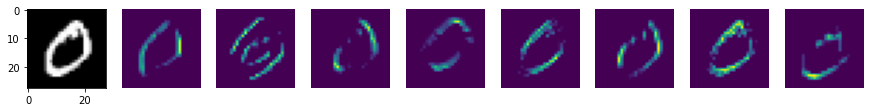

In [60]:
draw_feature_maps(1)

1/1 [==============================] - 0s 8ms/step


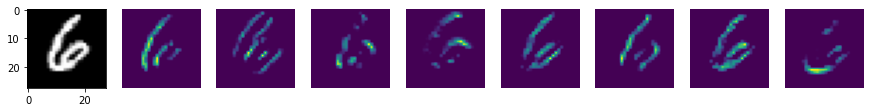

In [61]:
draw_feature_maps(13)

1/1 [==============================] - 0s 9ms/step


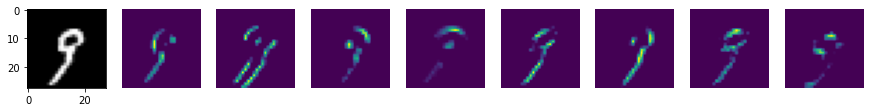

In [62]:
draw_feature_maps(19)

1/1 [==============================] - 0s 7ms/step


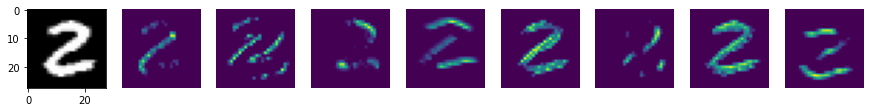

In [63]:
draw_feature_maps(25)